In [1]:
%matplotlib widget
import numpy as np
from crpropa import *
try:
    from mayavi import mlab
except:
    pass
import pandas as pd
import matplotlib.pyplot as plt

import FieldlineIntegrator as fli

In [2]:
def getFieldLine(bfield, pos, length, precision=1e-4, minStep=1*pc, maxStep=1*pc):
    """Creates a field line
    
    Uses the FieldlineIntegrator from FieldlineIntegrator to integrate
    a magnetic field line from a starting position into both directions.
    The length of the fieldline will be >~length.
    
    input
        bfield: CRPropa magnetic field
        pos:    start position
        length: total length of the integrated field line
        precision: error tolerance of the integration algorithm
        minStep: minimal step used in the integration
        maxStep: maximal step used in the integration
    
    returns
        np.array - coordinates of the fieldline including start position,
            ordering of the entries is: [start position, 
            all positions anti-parallel to magnetic field direction,
            all positions parallel to magnetic field direction]
  
    """
        
    FLI = fli.FieldlineIntegrator(bfield, precision, minStep, maxStep, False)
    FLI2 = fli.FieldlineIntegrator(bfield, precision, minStep, maxStep, True)
    
    c = Candidate()
    c.source.setPosition(pos)
    c.current.setPosition(pos)
    
    fieldline = [np.array(c.current.getPosition())]
    
    while c.getTrajectoryLength() < length/2.:
        FLI.process(c)
        fieldline.append(np.array(c.current.getPosition()))
    
    c.current.setPosition(pos)
    while c.getTrajectoryLength() < length:
        FLI2.process(c)
        fieldline.append(np.array(c.current.getPosition()))
        
    return np.array(fieldline)

In [3]:
bfield = UniformMagneticField(Vector3d(0,0,1))
pos = Vector3d(0)
length = 10*pc

In [4]:
fieldline = getFieldLine(bfield, pos, length)/pc

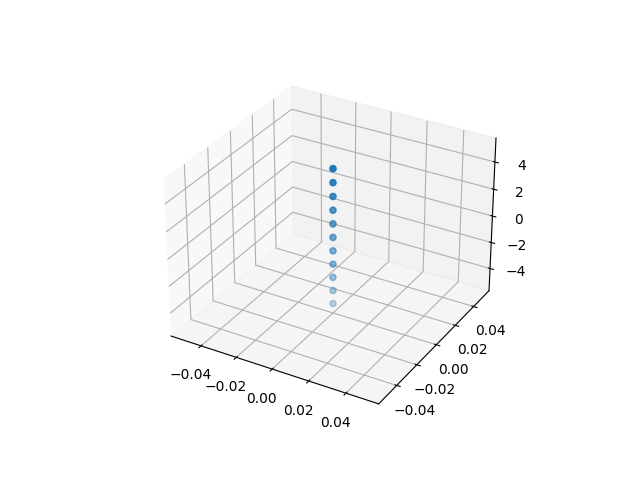

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")

ax.scatter(fieldline[:,0], fieldline[:,1], fieldline[:,2])
plt.show()

### Creating magnetic field lines with 20 kpc length
#### Field lines starting in a very thin Zylinder around the galactic disc

In [ ]:
MagField = JF12FieldSolenoidal()

step = 1*pc
Lmax = 10000*pc
N = 10000
n = 100
FLI = fli.FieldlineIntegrator(MagField, 1e-4, step, step, False)
FLI2 = fli.FieldlineIntegrator(MagField, 1e-4, step, step, True)

x, y, z, s, connections = [], [], [], [], []

PS_List = []

for i in range(n):
    PS = ParticleState()
    src = SourceUniformCylinder(Vector3d(0)*kpc, 0.0*kpc, 6*kpc)
    src.prepareParticle(PS)
    PS.setId(nucleusId(1,1))
    PS_List.append(PS)

for i in range(2*n):
    
    c = Candidate(PS_List[i//2])
    if i%2==0:
        x.append(c.current.getPosition().x / kpc)
        y.append(c.current.getPosition().y / kpc)
        z.append(c.current.getPosition().z / kpc)
        s.append(0)
    count = 1
    count = 0
    while c.getTrajectoryLength() < Lmax:
        if i%2==0: 
            FLI.process(c)
        else:
            FLI2.process(c)
        x.append(c.current.getPosition().x / kpc)
        y.append(c.current.getPosition().y / kpc)
        z.append(c.current.getPosition().z / kpc)
        s.append(count)
        count += 1
    connectors = np.vstack([np.arange(0,   N),np.arange(1, N+1)]).T
    if i%2==1:
        connectors[0][0] = 0
    connections.append(connectors)

The plotting below requieres mayavi

In [ ]:
# Create the points
src = mlab.pipeline.scalar_scatter(x, y, z, s)
mlab.outline()
mlab.axes()

# Connect them
src.mlab_source.dataset.lines = connections
src.update()

# The stripper-filter cleans up connected lines
lines = mlab.pipeline.stripper(src)

# Finally, display the set of lines
mlab.pipeline.surface(lines, colormap='viridis', line_width=2., opacity=1.)


mlab.show()